# Dynamic Linear Model using Kalman Filter

## Example for Online Linear Regression

In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
%matplotlib inline

EM Algorithm for a Linear Gaussian model specified by
$$x_0 = Normal(\mu_0, \Sigma_0)$$
$$x_{t+1} = A x_{t} + b_t + Normal(0,Q_t)$$
$$z_t = C x_t + d_t + Normal(0,R_t)$$

In [2]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [3]:
actual = np.array([-4.9*(tau*n)**2 for n in range(40)])
cameral = actual + np.random.randn(40)*3
state_means,state_cov = kf.filter(cameral)

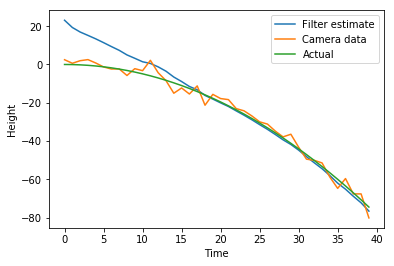

In [4]:
times = [n for n in range(40)]
plt.plot(times, state_means[:,0])
plt.plot(times, cameral)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

We can use a Kalman filter to model non-linear transition and observation functions, as well. For this purpose there exist extended and unscented Kalman filters, the latter of which is included in pykalman. These can even model situations where noise is not additive (for example, where noise is proportional to the size of the measurement). We can also specify non-Gaussian errors; this is useful in financial data, which tends to have heavy-tailed distributions.

Beta hedge: How to hedge your algorithm against your risk factors

## Stock Price Prediction Using Kalman Filter

### Dynamics of Price
Based on the celebrated APT model and Berra's risk model, I proposed the stock forecasting model as the following expression.

$$r_{i}(t) = \alpha_i(t) + \sum_{k=1}^K \beta_{ik}(t) F_{ik}(t)$$

Note that here we don't assume the excessive return or factor returns to be constant, which is different comparing to APT and Berra model. The traditional way to handle it is doing the time-series calibration (APT) or cross-section regression (Barra). And we would implement in the end of this part. Alternatively, we can call it dynamic linear model.



## Input data

- price_df
- instrument_df
- equity_df


- healthcare_universe
- healthcare_subset


- healthcare_equity_df
- benchmark_df


- factor_zscore: healthcare universe factor zscore
- subset_factor_zscore: healthcare subset factor zscore



In [1]:
from rqdata_utils import *
import pandas
import numpy as np
import scipy as sp
import alphalens as al
from pykalman import KalmanFilter
%matplotlib inline

In [2]:
price_df,instrument_df,equity_df = get_price_instrument_equity("cn_stock_price_2012_2018.csv","cn_instrument_info_2012_2018.csv","cn_equity_daily_2012_2018.csv","sectorCode")

In [3]:
healthcare_universe = instrument_df.index[instrument_df.sectorCode=='HealthCare'].values
len(healthcare_universe)

164

In [4]:
def equity_universe_filtering(equity_df, universe):
    universeFilter = [book_id in set(universe) for book_id in equity_df.index.get_level_values(level=1).values]
    return equity_df[universeFilter]

In [6]:
healthcare_equity_df = equity_universe_filtering(equity_df, healthcare_universe)
healthcare_equity_df.head()

return    close  total_turnover     volume  \
date       order_book_id                                                 
2012-01-04 000004.XSHE   -0.022250   7.9100      3763832.88   465469.0   
           000028.XSHE   -0.045433  19.8422      9326924.28   450553.0   
           000150.XSHE   -0.030295   3.1737      3109304.50   952600.0   
           000153.XSHE   -0.028053   5.7700      9673054.49  1596020.0   
           000403.XSHE    0.000000   3.1625            0.00        0.0   

                            week   month report_quarter    market_cap  \
date       order_book_id                                                
2012-01-04 000004.XSHE    0.5720  0.7506         2011q3  6.642556e+08   
           000028.XSHE    0.4201  0.2722         2011q3  5.872485e+09   
           000150.XSHE    0.3460  0.3610         2011q3  1.036800e+09   
           000153.XSHE    0.6830  2.4594         2011q3  1.531454e+09   
           000403.XSHE    0.0000  0.0000            NaN           NaN   

                          a_share_market_val_2  \
date       order_book_id                         
2012-01-04 000004.XSHE            6.634549e+08   
           000028.XSHE            4.753820e+09   
           000150.XSHE            1.036800e+09   
           000153.XSHE            1.360856e+09   
           000403.XSHE                     NaN   

                          cash_received_from_sales_of_goods  pb_ratio  \
date       order_book_id                                                
2012-01-04 000004.XSHE                         5.949968e+07    8.8175   
           000028.XSHE                         1.053298e+10    4.3493   
           000150.XSHE                         4.913279e+07    1.4763   
           000153.XSHE                         1.329425e+09    2.1169   
           000403.XSHE                                  NaN       NaN   

                            net_profit  ps_ratio  sectorCode  
date       order_book_id                                      
2012-01-04 000004.XSHE    4.500363e+06   37.5796  HealthCare  
           000028.XSHE    2.481834e+08    0.3414  HealthCare  
           000150.XSHE    3.657858e+06    7.8956  HealthCare  
           000153.XSHE    1.560397e+07    0.7818  HealthCare  
           000403.XSHE             NaN       NaN  HealthCare

In [7]:
benchmark_df = pd.read_csv("cn_SH_healthcare_index_2012_2018.csv",names=['date','value'])
benchmark_df = benchmark_df.set_index('date',drop=True)
benchmark_df['return'] = np.log(benchmark_df.shift(1)/benchmark_df).fillna(0)
benchmark_df.head()

,value,return
date,,
2012-01-04,2891.462,0.000000
2012-01-05,2766.955,0.044015
2012-01-06,2744.793,0.008042
2012-01-09,2833.219,-0.031708
2012-01-10,2929.594,-0.033450


In [8]:
healthcare_equity_df['market_cap'].fillna(0).head()

date        order_book_id
2012-01-04  000004.XSHE      6.642556e+08
            000028.XSHE      5.872485e+09
            000150.XSHE      1.036800e+09
            000153.XSHE      1.531454e+09
            000403.XSHE      0.000000e+00
Name: market_cap, dtype: float64

In [9]:
factor_list = ['market_cap', 'pb_ratio', 'ps_ratio']
factor_size = len(factor_list)

data_copy = healthcare_equity_df[factor_list].fillna(0)
factor_zscore = (data_copy - data_copy.groupby(level='date').mean())/data_copy.groupby(level='date').std()
factor_zscore.head()

market_cap  pb_ratio  ps_ratio
date       order_book_id                                
2012-01-04 000004.XSHE     -0.784393 -0.115692  4.830427
           000028.XSHE     -0.093343 -0.124286 -0.672507
           000150.XSHE     -0.734962 -0.129812  0.443827
           000153.XSHE     -0.669329 -0.128580 -0.607426
           000403.XSHE     -0.872529 -0.132652 -0.722958

In [11]:
idx = pandas.IndexSlice

healthcare_subset = set(healthcare_universe)

for date,group in factor_zscore.groupby(level=0):
#     print(size)
    size = group.shape[0]
#     print(date,size)
#     print(group)
    new_set = set(group.loc[idx[:,healthcare_subset],:].index.get_level_values(1).values)
    if(new_set<healthcare_subset):
        healthcare_subset = new_set
#         print(healthcare_subset)
        
subset_factor_zscore = factor_zscore.loc[idx[:,healthcare_subset],:]
asset_size = len(healthcare_subset)
print(asset_size)


63


## Time-series Regression
From APT theory, we assume the sources of the randomness are factor returns. Which means factor exposure $\beta$ is a constant for each (asset, factor) pair and doesn't depend on time. Here, we assume that we already knew the factor loadings and it's time-dependent. However, the factor returns are not supposed to be dependent on stocks, it should be an indogeneous property of each factor, so time-series calibration is not perfect

In [14]:
import statsmodels.api as sm
from statsmodels import regression,stats


ts_factor_zscore = sm.add_constant(factor_zscore.dropna())

Y = [healthcare_equity_df.xs(asset,level=1)['return'] for asset in healthcare_subset]
X = [ts_factor_zscore.xs(asset,level=1)[['market_cap','pb_ratio','ps_ratio','const']] for asset in healthcare_subset]
reg_results = [regression.linear_model.OLS(y,x).fit().params for y,x in zip(Y,X) if not(x.empty or y.empty)]
indices = [asset for y, x, asset in zip(Y, X, healthcare_subset) if not(x.empty or y.empty)]
ts_F_df = pd.DataFrame(reg_results, index=indices)
ts_F_df.head()

,market_cap,pb_ratio,ps_ratio,const
600789.XSHG,0.025873,0.001299,0.001113,0.017211
600721.XSHG,-0.008367,0.000223,0.000256,-0.005176
000999.XSHE,0.001759,-0.002473,0.001878,-0.000998
000919.XSHE,0.053181,-0.016566,0.000339,0.019037
600211.XSHG,0.000640,0.000864,-0.001295,0.000808


## Cross-sectional Regression
Here, we fixed the time-stamp and do the regression across the healthcare universe. From the result we can see the factor returns are constant (not dependent on each stock), which is good, but the alpha is also a constant which is supposed to be different for each stock.

In [36]:
import statsmodels.api as sm
from statsmodels import regression,stats

for date,group in subset_factor_zscore.groupby(level=0):
    X = sm.add_constant(group.loc[:,('market_cap','pb_ratio','ps_ratio')])
    y = healthcare_equity_df.loc[(date,list(healthcare_subset)),'return']
#     print(X)
#     print(y)
    results = sm.regression.linear_model.OLS(y,X).fit()
    print(results.summary())
    print(results.params)
    break

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     5.202
Date:                Mon, 07 May 2018   Prob (F-statistic):            0.00296
Time:                        13:51:20   Log-Likelihood:                 160.16
No. Observations:                  63   AIC:                            -312.3
Df Residuals:                      59   BIC:                            -303.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0283      0.002    -11.417      0.0

## Kalman Filter
In order to address both problems in time-series calibration and cross-section regression, we use a powerful tool: Kalman Filter. We have the following anatomic version of the model to match the parameters setting for Kalman filter
$$
\left(\begin{array}{cc} 
a_1(t)\\
\vdots\\
a_n(t)\\
F_1(t)\\
\vdots\\
F_K(t)
\end{array}\right)
=
\left(\begin{array}{cc} 
1&\dots &0&0&\dots&0\\
\vdots&\ddots&\vdots&\vdots&\dots &\vdots\\
0&\dots&1&0&\dots&0\\
0&\dots&0&1&\dots&0\\
\vdots&\dots&\vdots&\vdots&\ddots&\vdots\\
0&\dots&0&0&\dots&1\\
\end{array}\right)
\left(\begin{array}{cc} 
a_1(t)\\
\vdots\\
a_n(t)\\
F_1(t)\\
\vdots\\
F_K(t)
\end{array}\right)
+ \Sigma(\mbox{state})
$$ 

$$
\left(\begin{array}{cc} 
R_1(t)\\
\vdots\\
R_n(t)\\
\end{array}\right)
=
\left(\begin{array}{cc} 
1 & 0 &\dots &0&b_{11}(t) &b_{12}(t)&\dots&b_{1K}(t)\\
0 & 1 &\dots &0&b_{21}(t) &b_{22}(t)&\dots&b_{2K}(t)\\
\vdots& \vdots&\ddots&\vdots&\vdots&\vdots&\vdots&\vdots\\
0& 0 &\dots &1&b_{n1}(t) &b_{n2}(t)&\dots&b_{nK}(t)
\end{array}\right)
\left(\begin{array}{cc} 
a_1(t)\\
\vdots\\
a_n(t)\\
F_1(t)\\
\vdots\\
F_K(t)
\end{array}\right)
+ \Sigma(\mbox{observation})
$$ 

Here, we assume the variance to each parameter is 0.01 here, and covariance between two different factors is zero.

In [21]:
observation_transition_matrix = []
for date,group in subset_factor_zscore.groupby(level=0):
    exposure_matrix = group.values
#     print(np.shape(group.values))
#     print(np.shape(exposure_matrix))
#     print(exposure_matrix.shape)
#     print(healthcare_size)
    observation_transition_matrix.append(np.concatenate((np.eye(asset_size),exposure_matrix),axis=1).tolist())


In [22]:
observations = healthcare_equity_df.loc[pd.IndexSlice[:,healthcare_subset],'return']

In [23]:
observation_list = []
for date,group in observations.groupby(level=0):
#     print(date)
    observation_list.append(group.values.tolist())

In [24]:
np.shape(observation_transition_matrix)

(1535, 63, 66)

In [36]:
state_transition_matrix = np.eye(factor_size+asset_size)
state_covariance_matrix = np.eye(factor_size+asset_size)*0.01
observation_matrices = observation_transition_matrix
observation_covariance_matrix = np.eye(asset_size)*0.0
initial_state_mean = np.zeros(factor_size+asset_size)
initial_state_covariance = np.eye(factor_size+asset_size)*0.01


nstate = factor_size+asset_size
nobs = asset_size
print(state_transition_matrix.shape)
print(state_covariance_matrix.shape)
print(np.shape(observation_matrices))
print(observation_covariance_matrix.shape==(nobs,nobs))
print(initial_state_mean.shape==(nstate,))
print(initial_state_covariance.shape==(nstate,nstate))


kf = KalmanFilter(transition_matrices=state_transition_matrix,
                 transition_covariance=state_covariance_matrix,
                 observation_matrices=observation_matrices,
                 observation_covariance=observation_covariance_matrix,
                 initial_state_mean=initial_state_mean,
                 initial_state_covariance=initial_state_covariance,
                 n_dim_state=nstate,
                 n_dim_obs=nobs)

(66, 66)
(66, 66)
(1535, 63, 66)
True
True
True


In [37]:
returns = kf.filter(observation_list)

In [38]:
filtered_state_means = returns[0]
filtered_state_means

array([[ -4.03170092e-02,  -4.22587014e-02,  -3.22438707e-02, ...,
         -1.72686818e-03,   7.18235474e-03,   3.63175090e-03],
       [ -8.04559245e-02,  -6.09172113e-02,  -3.54426821e-02, ...,
          4.34147689e-03,  -7.26471015e-04,   2.25155185e-03],
       [ -1.32326309e-02,  -2.29379961e-02,  -2.78122436e-03, ...,
          3.35210709e-03,  -4.65540870e-04,   4.28954215e-03],
       ..., 
       [ -9.14206039e-02,  -1.58927740e-02,   2.46211644e-02, ...,
          4.30812908e-01,   1.33497100e-01,   1.33606232e-03],
       [ -9.79291269e-02,  -3.19932704e-02,   2.83323311e-02, ...,
          4.31024068e-01,   1.35620040e-01,  -1.23446537e-04],
       [ -6.97343193e-02,   2.25549858e-02,   4.27761974e-02, ...,
          4.37354078e-01,   1.29546549e-01,   6.69461062e-03]])

In [39]:
a_list = []
F_list = []
for state in filtered_state_means:
    a = state[:asset_size]
    F = state[asset_size:]
    a_list.append(a)
    F_list.append(F)

In [40]:
import itertools

a_df = pd.Series(list(itertools.chain(*a_list)),index = subset_factor_zscore.index,name='alpha')
a_df.head()

date        order_book_id
2012-01-04  000004.XSHE     -0.040317
            000028.XSHE     -0.042259
            000150.XSHE     -0.032244
            000153.XSHE     -0.026079
            000403.XSHE      0.002072
Name: alpha, dtype: float64

In [41]:
F_list_temp = [[F,]*asset_size for F in F_list]
# subset_factor_zscore.index.get_level_values(0).unique()
F_list_temp = list(itertools.chain(*F_list_temp))
F_df = pd.DataFrame(F_list_temp,columns=['market_cap_F','pb_ratio_F','ps_ratio_F'],index=subset_factor_zscore.index)
F_df.head()

market_cap_F  pb_ratio_F  ps_ratio_F
date       order_book_id                                      
2012-01-04 000004.XSHE       -0.001727    0.007182    0.003632
           000028.XSHE       -0.001727    0.007182    0.003632
           000150.XSHE       -0.001727    0.007182    0.003632
           000153.XSHE       -0.001727    0.007182    0.003632
           000403.XSHE       -0.001727    0.007182    0.003632

In [42]:
return_df = healthcare_equity_df.loc[idx[:,healthcare_subset],'return']
close_df = healthcare_equity_df.loc[idx[:,healthcare_subset],'close']
close_df.head()

date        order_book_id
2012-01-04  000004.XSHE       7.9100
            000028.XSHE      19.8422
            000150.XSHE       3.1737
            000153.XSHE       5.7700
            000403.XSHE       3.1625
Name: close, dtype: float64

In [43]:
subset_kf_df = pd.concat([subset_factor_zscore,F_df,a_df,return_df,close_df],axis=1)
subset_kf_df.head()

market_cap  pb_ratio  ps_ratio  market_cap_F  \
date       order_book_id                                                 
2012-01-04 000004.XSHE     -0.784393 -0.115692  4.830427     -0.001727   
           000028.XSHE     -0.093343 -0.124286 -0.672507     -0.001727   
           000150.XSHE     -0.734962 -0.129812  0.443827     -0.001727   
           000153.XSHE     -0.669329 -0.128580 -0.607426     -0.001727   
           000403.XSHE     -0.872529 -0.132652 -0.722958     -0.001727   

                          pb_ratio_F  ps_ratio_F     alpha    return    close  
date       order_book_id                                                       
2012-01-04 000004.XSHE      0.007182    0.003632 -0.040317 -0.022250   7.9100  
           000028.XSHE      0.007182    0.003632 -0.042259 -0.045433  19.8422  
           000150.XSHE      0.007182    0.003632 -0.032244 -0.030295   3.1737  
           000153.XSHE      0.007182    0.003632 -0.026079 -0.028053   5.7700  
           000403.XSHE      0.007182    0.003632  0.002072  0.000000   3.1625

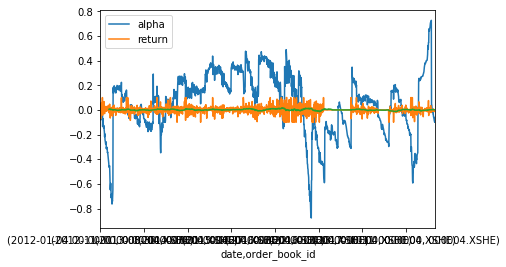

In [44]:
subset_kf_df.loc[idx[:,'000004.XSHE'],('alpha','return')].plot()
subset_kf_df.loc[idx[:,'000004.XSHE'],('return')].rolling(40).mean().plot()

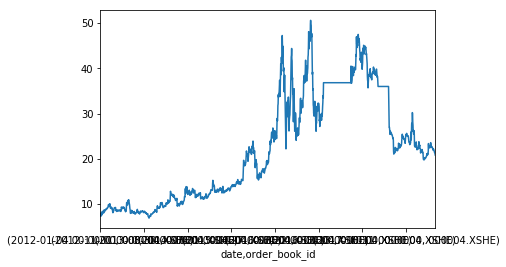

In [45]:
subset_kf_df.loc[idx[:,'000004.XSHE'],'close'].plot()

## Return-neutralize: Demean the returns among cross-section

In [77]:
#demean
demean_observation_list = []
for date,group in observations.groupby(level=0):
#     print(date)
#     print(group)
#     print(group - group.mean())
    demean_observation_list.append((group-group.mean()).values.tolist())

In [83]:
a = [[1,2],[44,5]]
list(itertools.chain(*a))
len(list(itertools.chain(*demean_observation_list)))

96705

In [87]:
demean_return_df = pd.Series(list(itertools.chain(*demean_observation_list)),
                             index=subset_factor_zscore.index,name='demean_return')
demean_return_df.head()

date        order_book_id
2012-01-04  000004.XSHE      0.005969
            000028.XSHE     -0.017213
            000150.XSHE     -0.002076
            000153.XSHE      0.000166
            000403.XSHE      0.028219
Name: demean_return, dtype: float64

(66, 66)
(66, 66)
(1535, 63, 66)
True
True
True
(1535, 63)
(96705,)


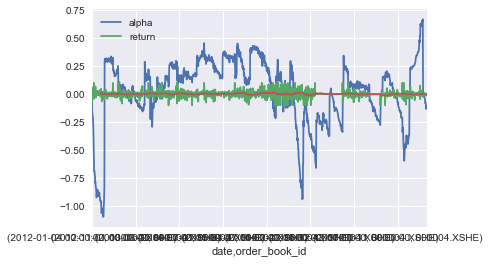

In [95]:
state_transition_matrix = np.eye(factor_size+asset_size)
state_covariance_matrix = np.eye(factor_size+asset_size)*0.001
observation_matrices = observation_transition_matrix
observation_covariance_matrix = np.eye(asset_size)*0.00
initial_state_mean = np.zeros(factor_size+asset_size)
initial_state_covariance = np.eye(factor_size+asset_size)*0.1


nstate = factor_size+asset_size
nobs = asset_size
print(state_transition_matrix.shape)
print(state_covariance_matrix.shape)
print(np.shape(observation_matrices))
print(observation_covariance_matrix.shape==(nobs,nobs))
print(initial_state_mean.shape==(nstate,))
print(initial_state_covariance.shape==(nstate,nstate))
print(np.shape(demean_observation_list))
print(np.shape(demean_return_df))


kf = KalmanFilter(transition_matrices=state_transition_matrix,
                 transition_covariance=state_covariance_matrix,
                 observation_matrices=observation_matrices,
                 observation_covariance=observation_covariance_matrix,
                 initial_state_mean=initial_state_mean,
                 initial_state_covariance=initial_state_covariance,
                 n_dim_state=nstate,
                 n_dim_obs=nobs)

returns = kf.filter(demean_observation_list)
filtered_state_means = returns[0]
a_list = []
F_list = []
for state in filtered_state_means:
    a = state[:asset_size]
    F = state[asset_size:]
    a_list.append(a)
    F_list.append(F)
    
import itertools

a_df = pd.Series(list(itertools.chain(*a_list)),index = subset_factor_zscore.index,name='alpha')
a_df.head()
F_list_temp = [[F,]*asset_size for F in F_list]
# subset_factor_zscore.index.get_level_values(0).unique()
F_list_temp = list(itertools.chain(*F_list_temp))
F_df = pd.DataFrame(F_list_temp,columns=['market_cap_F','pb_ratio_F','ps_ratio_F'],index=subset_factor_zscore.index)
F_df.head()
return_df = healthcare_equity_df.loc[idx[:,healthcare_subset],'return']
close_df = healthcare_equity_df.loc[idx[:,healthcare_subset],'close']
close_df.head()

subset_kf_df = pd.concat([subset_factor_zscore,F_df,a_df,return_df,close_df],axis=1)
subset_kf_df.head()
subset_kf_df.loc[idx[:,'000004.XSHE'],('alpha','return')].plot()
subset_kf_df.loc[idx[:,'000004.XSHE'],('return')].rolling(40).mean().plot()

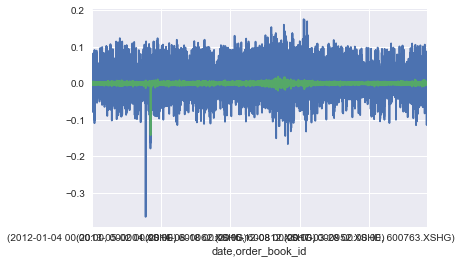

In [94]:
demean_return_df[demean_return_df>1] = 0
demean_return_df.plot()
demean_return_df.rolling(40).mean().plot()

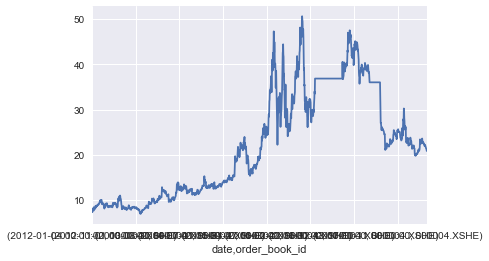

In [59]:
subset_kf_df.loc[idx[:,'000004.XSHE'],'close'].plot()